## Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load PPG Data From File

In [2]:
a = np.genfromtxt('../data/smooth movement.txt', delimiter=',')

fs = 50

raw_ppg = a[0:]
raw_time = []
for i in range(len(raw_ppg)):
    raw_time.append(i / fs)

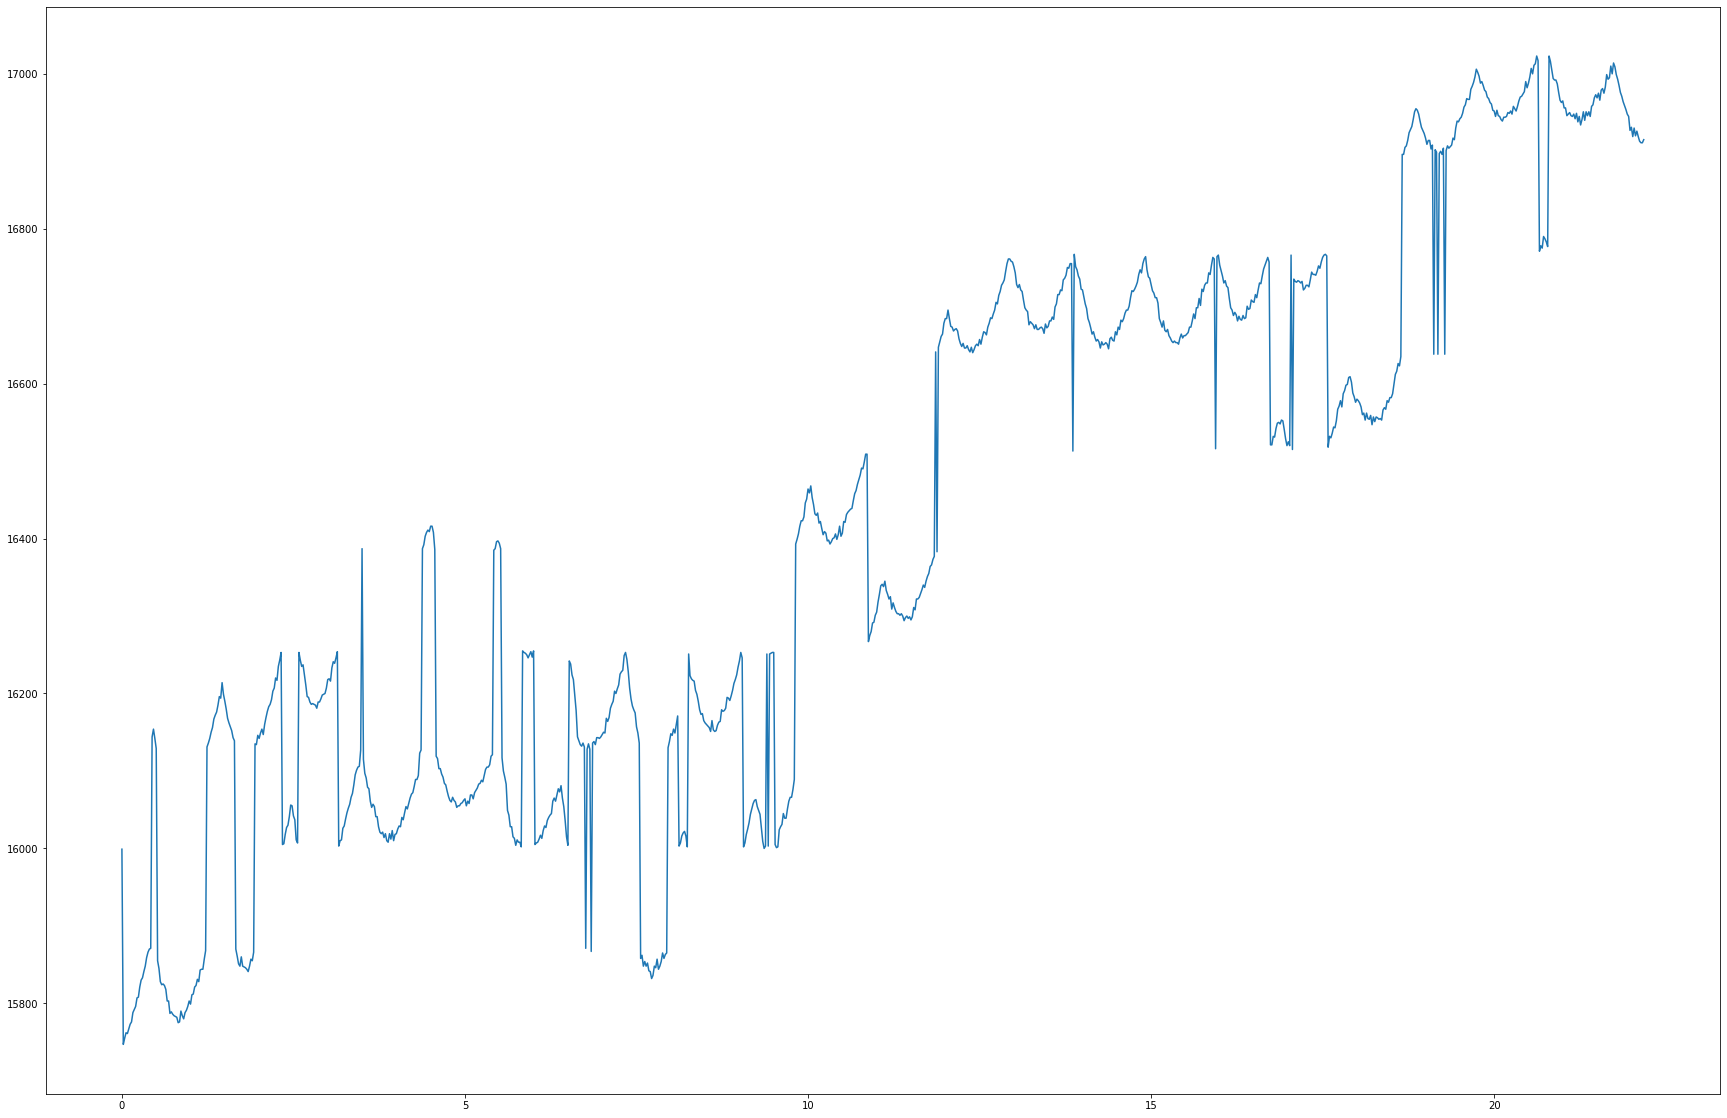

In [3]:
plt.subplots(figsize=(30,20))
plt.plot(raw_time, raw_ppg)

## Jump elimination

In [4]:
JUMP_THRESHOLD = 100
JUMP_DECAY = 0.125
jump = 0
prev_raw = raw_ppg[0]

time1 = raw_time.copy()
ppg1 = []
ppg1.append(raw_ppg[0])

for i in range(1, len(raw_ppg)):
    raw = raw_ppg[i]
    diff = raw - prev_raw
    prev_raw = raw
    if (diff > JUMP_THRESHOLD) or (diff < -JUMP_THRESHOLD):
        jump += diff
    value = raw - jump
    ppg1.append(value)
    if (jump > 0):
        jump -= JUMP_DECAY
    elif (jump < 0):
        jump += JUMP_DECAY

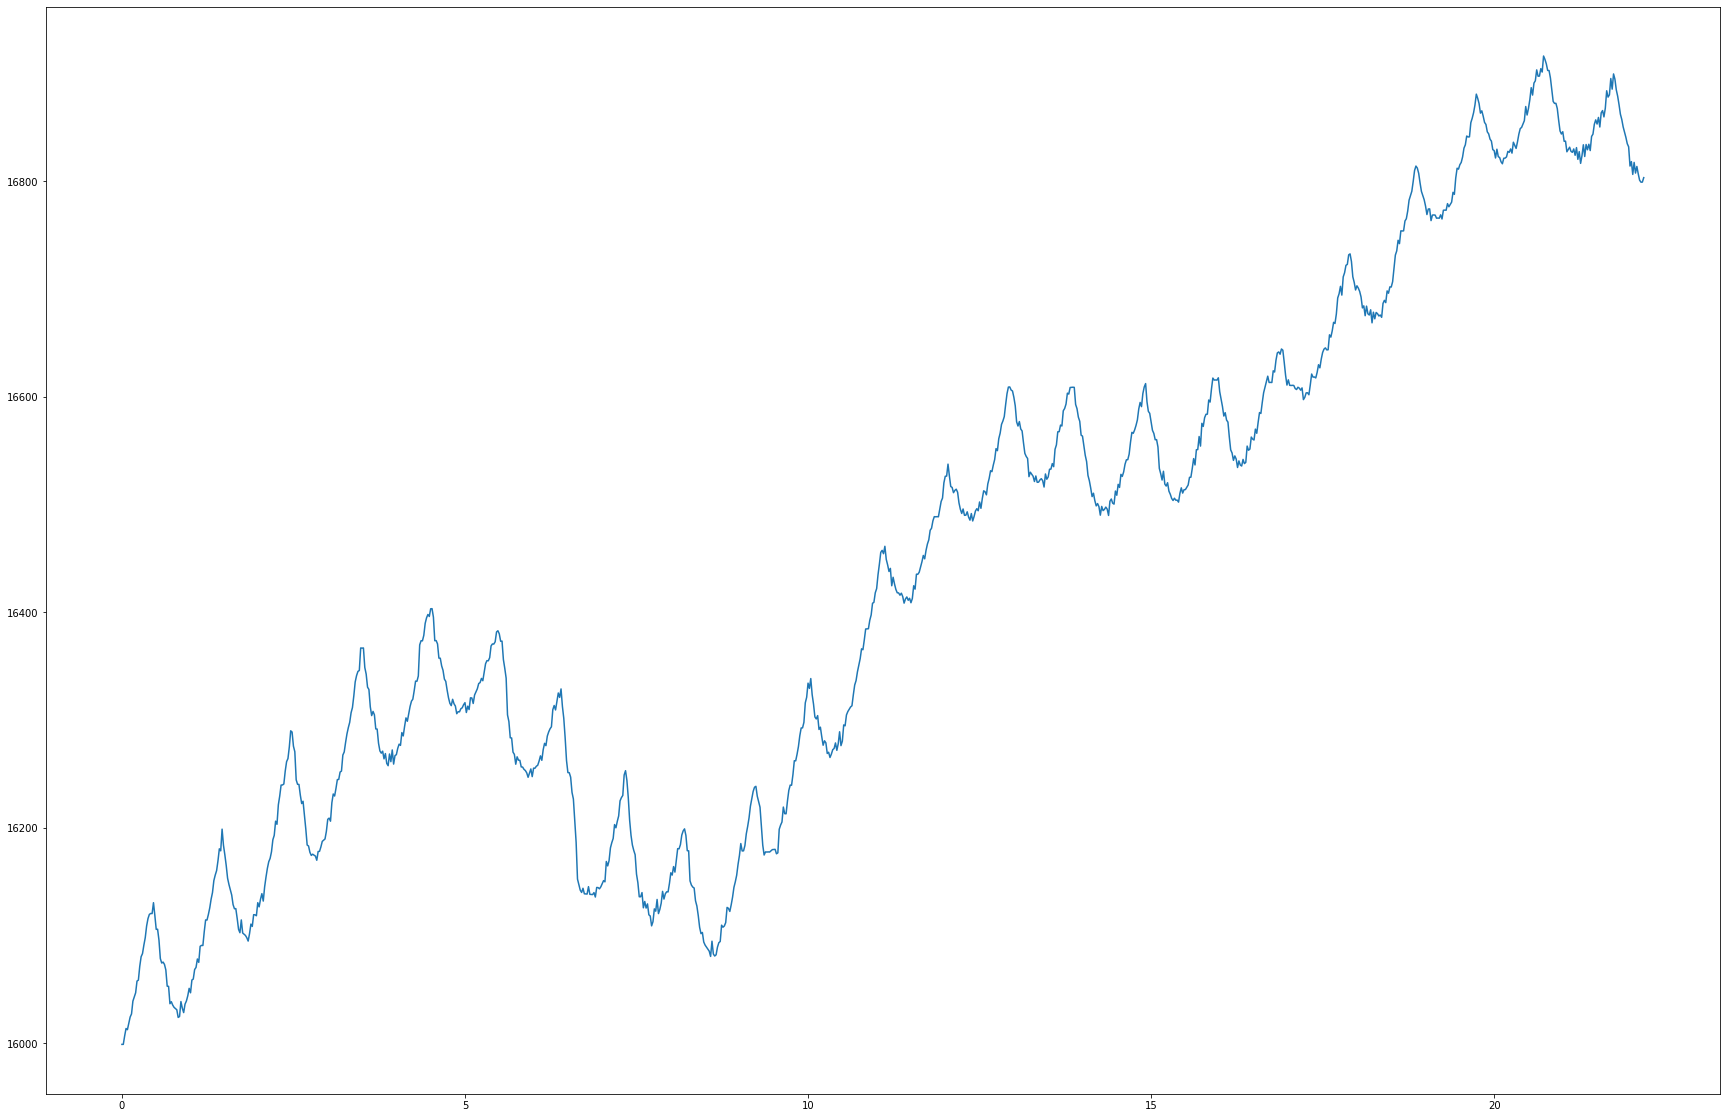

In [5]:
plt.subplots(figsize=(30,20))
plt.plot(time1, ppg1)

## Eliminate the constant term

In [6]:
avg1_num_one_side = int(fs/2)
avg1_num = avg1_num_one_side * 2 + 1
avg_ppg1 = []
first_index_1 = avg1_num_one_side
last_index_1 = len(ppg1) - avg1_num_one_side
temp = 0
calculated_temp = False

for i in range(first_index_1, last_index_1):
    if calculated_temp:
        temp = temp - ppg1[i - avg1_num_one_side] + ppg1[i + avg1_num_one_side]
    else:
        for j in range(0, avg1_num):
            temp += ppg1[j]
            calculated_temp = True
    avg_ppg1.append(temp / avg1_num)

ppg2 = []
for i in range(len(avg_ppg1)):
    ppg2.append(ppg1[first_index_1 + i] - avg_ppg1[i])
time2 = time1[first_index_1:last_index_1].copy()

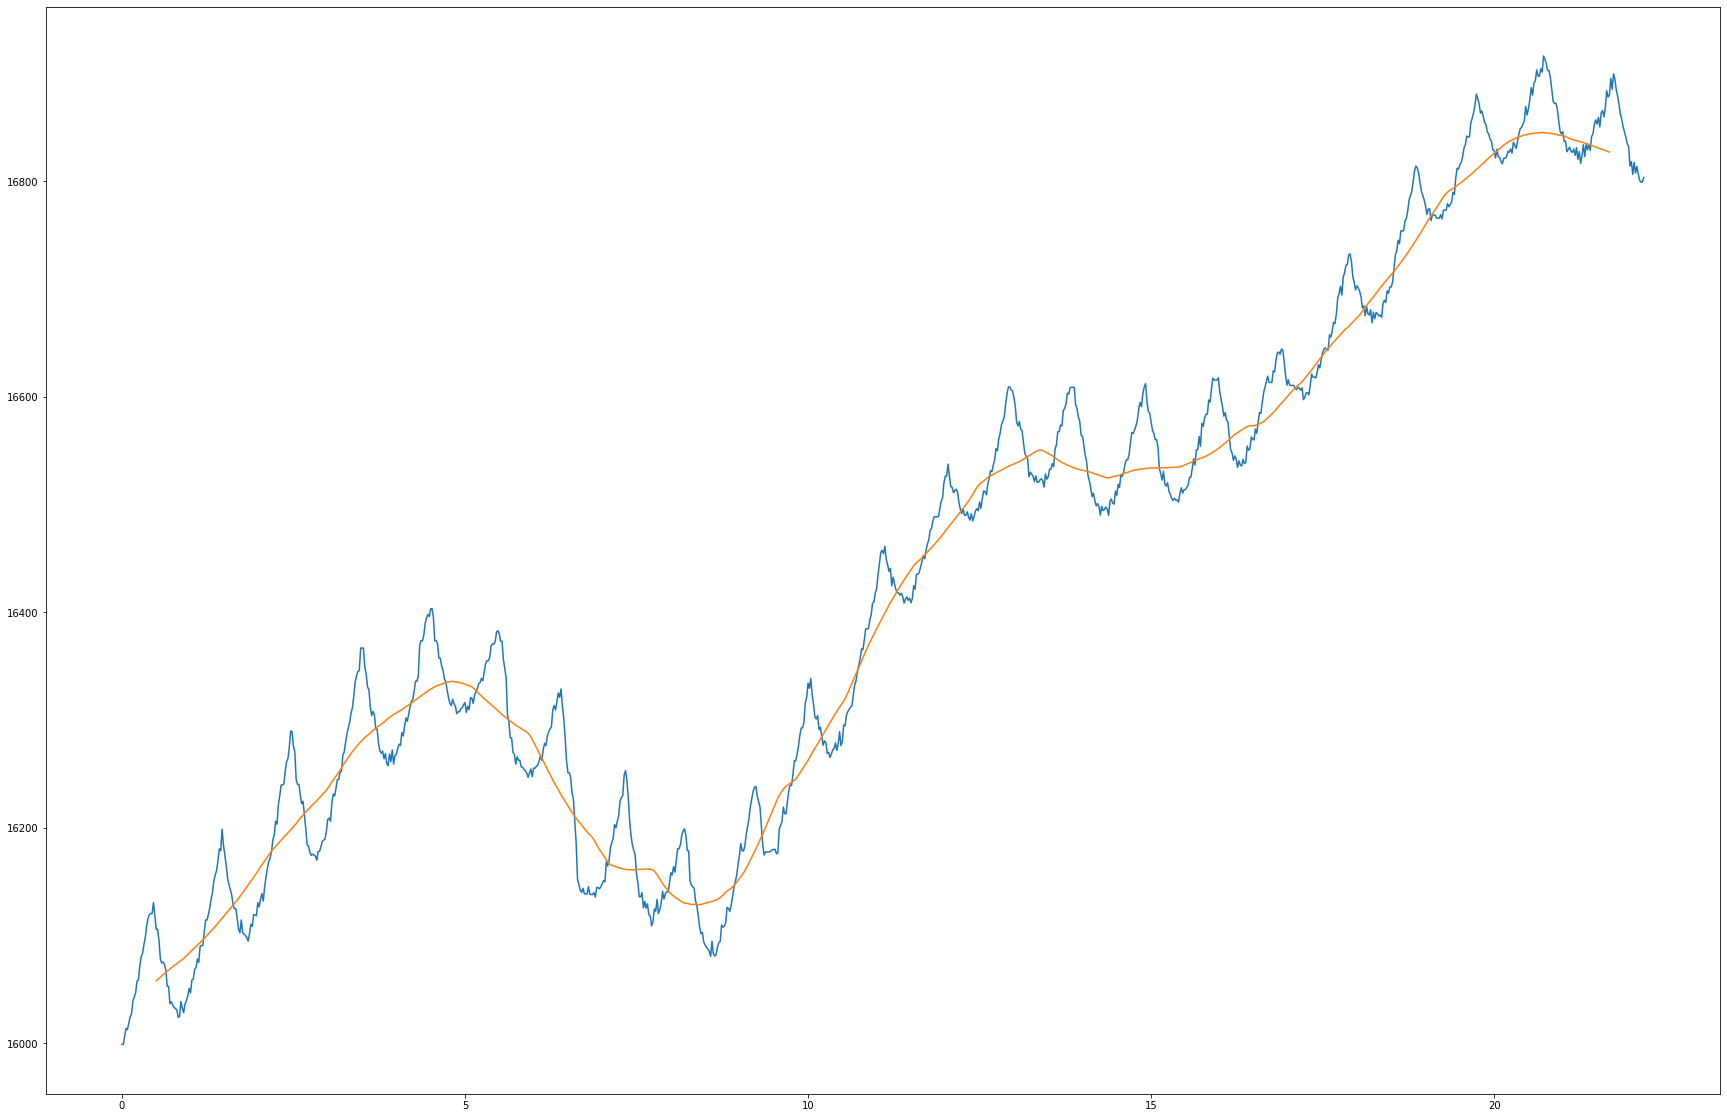

In [7]:
plt.subplots(figsize=(30,20))
plt.plot(time1, ppg1)
plt.plot(time2, avg_ppg1)

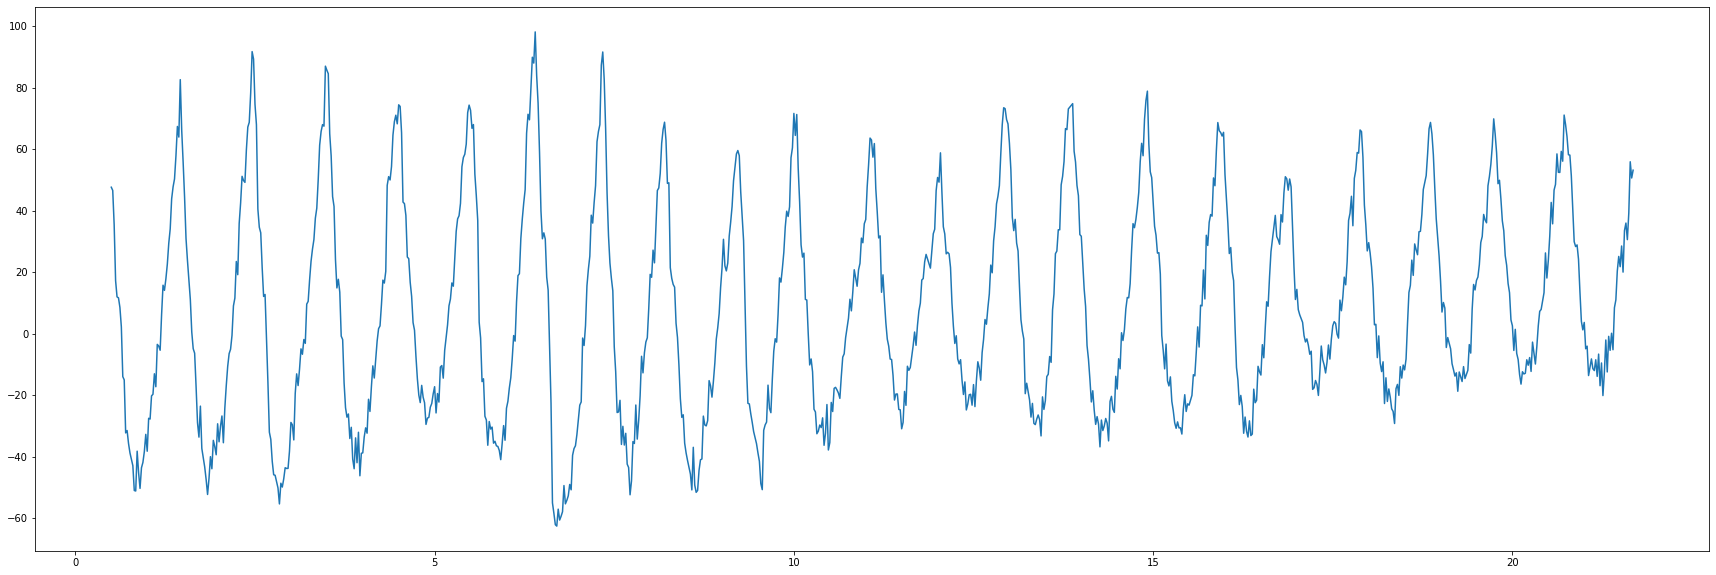

In [8]:
plt.subplots(figsize=(30,10))
plt.plot(time2, ppg2)

## Eliminate high frequency noise

In [9]:
avg2_num_one_side = int(fs/20)
avg2_num = avg2_num_one_side * 2 + 1
ppg = []
first_index_2 = avg2_num_one_side
last_index_2 = len(ppg2) - avg2_num_one_side
temp = 0
calculated_temp = False

for i in range(first_index_2, last_index_2):
    if calculated_temp:
        temp = temp - ppg2[i - avg2_num_one_side] + ppg2[i + avg2_num_one_side]
    else:
        for j in range(0, avg2_num):
            temp += ppg2[j]
            calculated_temp = True
    ppg.append(temp / avg2_num)
    
time = time2[first_index_2:last_index_2].copy()

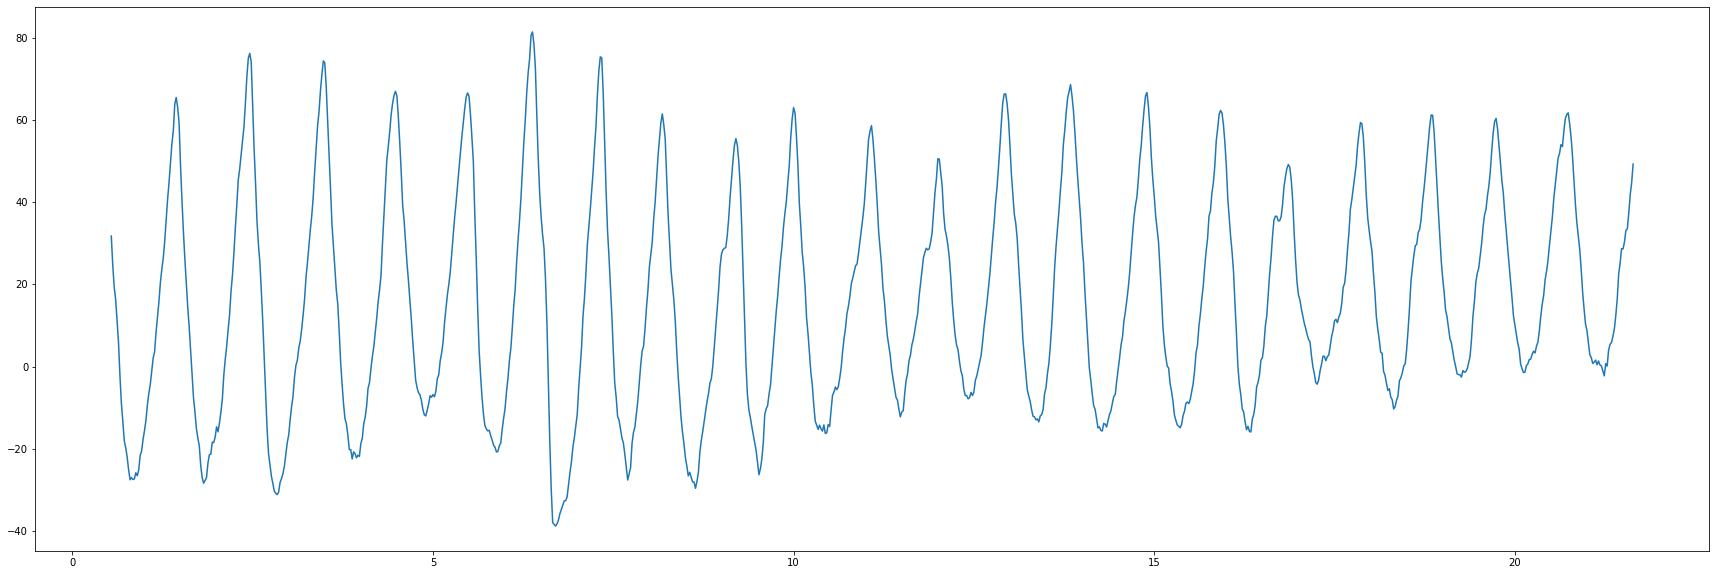

In [10]:
plt.subplots(figsize=(30,10))
plt.plot(time, ppg)

## Analyze frequency spectrum

### Get one window of data

In [11]:
# Window size should be power of 2.
# The higher it is, the better the resolution on the freq axis
window_size = 512
window_start = 0
data = ppg[window_start : window_start + window_size]

### Perform Fast Fourier Transform (FFT)

In [12]:
# Get the frequency spectrum
ft = np.fft.rfft(data)
# Calculate magnitude spectrum
mag_ft = np.absolute(ft)
# Scale frequency range from [0, 0.5] to [0, fs/2]
freq = np.fft.rfftfreq(len(data)) * fs * 60

In [13]:
f_res = fs * 60 / window_size
cutoff_freq = 300 #bpms
cutoff_index = int(cutoff_freq / f_res)

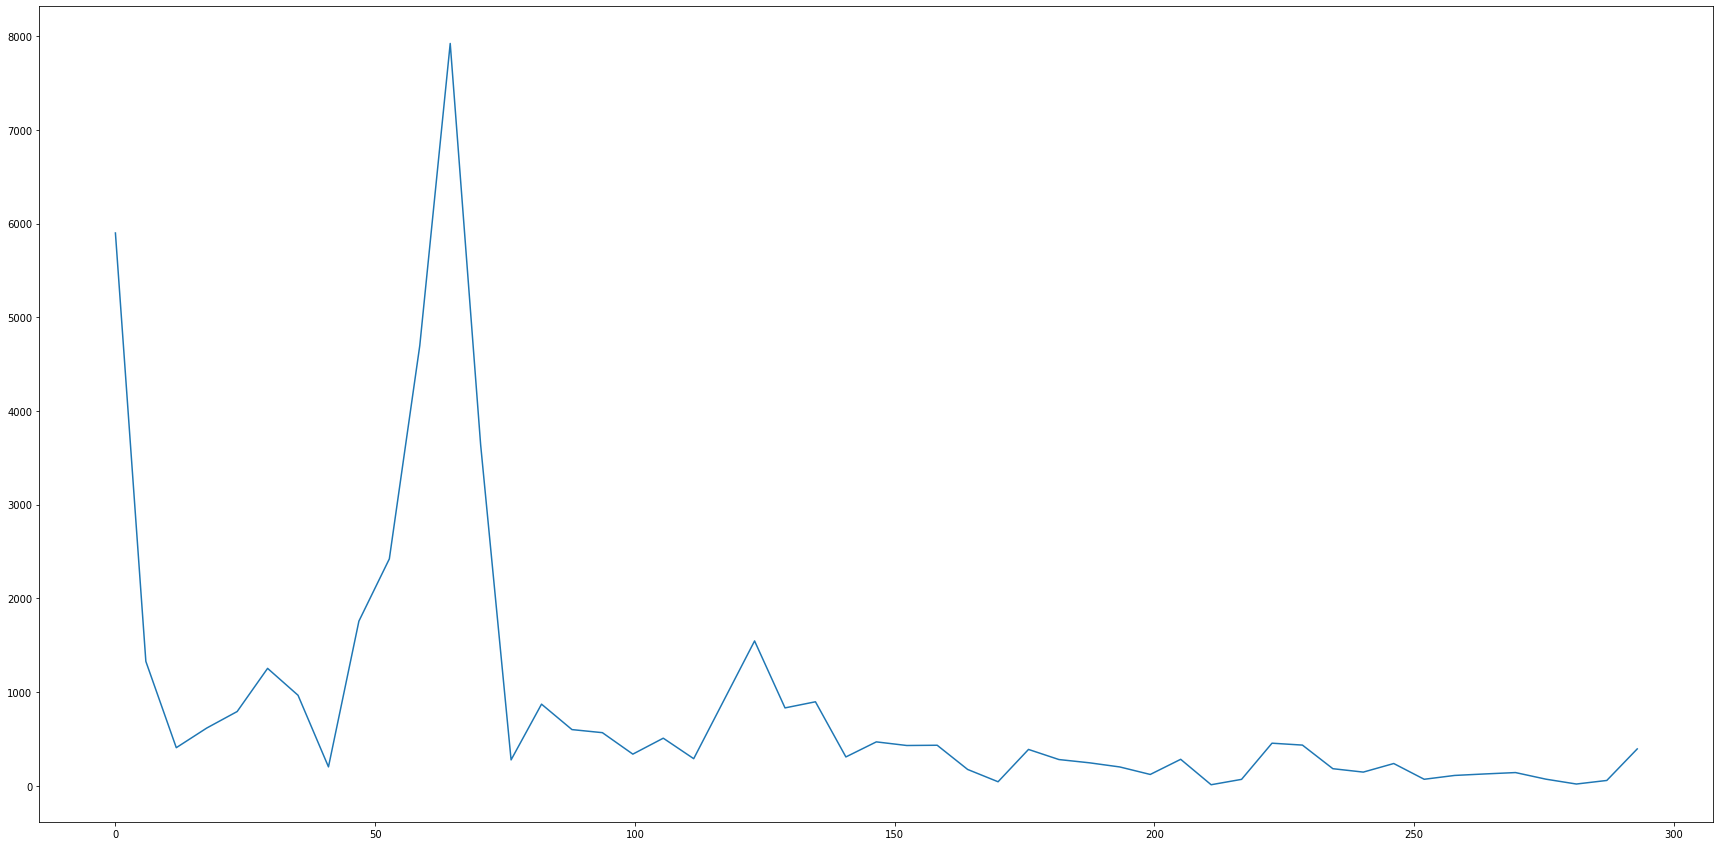

In [14]:
plt.subplots(figsize=(30,15))
plt.plot(freq[:cutoff_index], mag_ft[:cutoff_index])

## Find the heart rate frequency

In [15]:
# Find heart rate (where the magnitude peak is the highest)
hr_freq = 0
peak_index = 0
max_peak = 0
for i in range(1, cutoff_index):
    if mag_ft[i] > max_peak and mag_ft[i] > mag_ft[i-1] and mag_ft[i] > mag_ft[i+1]:
        max_peak = mag_ft[i]
        peak_index = i
if (peak_index == 0):
    hr_freq = 0
else:
    curr_m = max_peak
    prev_m = mag_ft[peak_index - 1]
    next_m = mag_ft[peak_index + 1]
    if prev_m > next_m:
        prev_m -= next_m
        curr_m -= next_m
        hr_freq = freq[peak_index] - f_res * prev_m / (prev_m + curr_m)
    elif prev_m < next_m:
        next_m -= prev_m
        curr_m -= prev_m
        hr_freq = freq[peak_index] + f_res * next_m / (next_m + curr_m)
    else:
        hr_freq = freq[peak_index]
print("Heart rate is:", hr_freq, "bpm")

Heart rate is: 63.291318710318755 bpm


## Analyze all window frame of data

In [16]:
window_size = 512
window_step = 20
data_length = len(ppg)
hr = []
hr_time = []

for k in range(0, data_length - window_size, window_step):
    data = ppg[k : k + window_size]
    ft = np.fft.rfft(data)
    mag_ft = np.absolute(ft)
    freq = np.fft.rfftfreq(len(data)) * fs * 60
    f_res = fs * 60 / window_size
    cutoff_freq = 300 #bpms
    cutoff_index = int(cutoff_freq / f_res)
    hr_freq = 0
    peak_index = 0
    max_peak = 0
    for i in range(1, cutoff_index):
        if mag_ft[i] > max_peak and mag_ft[i] > mag_ft[i-1] and mag_ft[i] > mag_ft[i+1]:
            max_peak = mag_ft[i]
            peak_index = i
    if (peak_index == 0):
        hr_freq = 0
    else:
        curr_m = max_peak
        prev_m = mag_ft[peak_index - 1]
        next_m = mag_ft[peak_index + 1]
        if prev_m > next_m:
            prev_m -= next_m
            curr_m -= next_m
            hr_freq = freq[peak_index] - f_res * prev_m / (prev_m + curr_m)
        elif prev_m < next_m:
            next_m -= prev_m
            curr_m -= prev_m
            hr_freq = freq[peak_index] + f_res * next_m / (next_m + curr_m)
        else:
            hr_freq = freq[peak_index]
        if (hr_freq < 30):
            hr_freq = 30
        hr.append(hr_freq)
        hr_time.append(time[k])

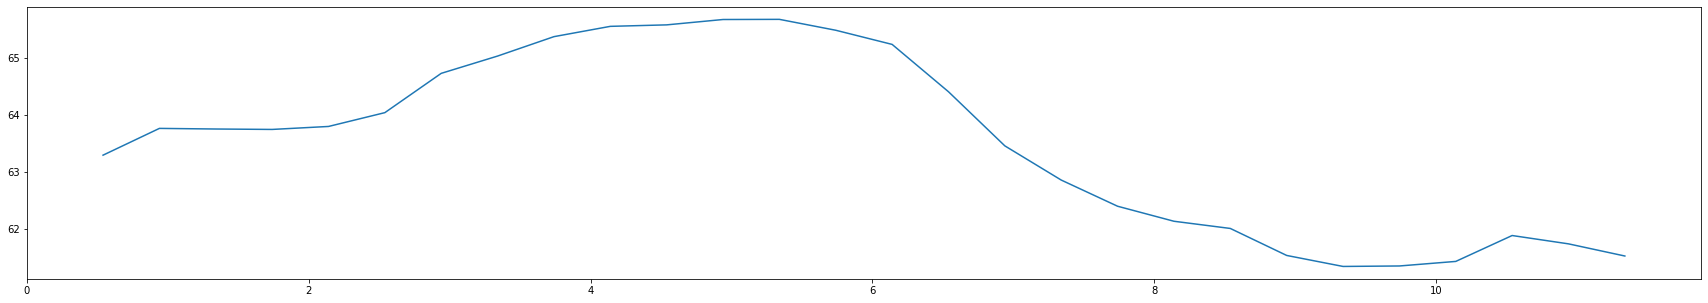

In [17]:
plt.subplots(figsize=(30,5))
plt.plot(hr_time, hr)